Determinación de $\beta / \nu$


In [5]:
import sys
sys.path.append('../../src/robustness/new')
from file1 import load_dataframes
import matplotlib.pyplot as plt

import fssa
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline

In [6]:
net_type = 'DT'
param = 'param'
attack = 'Ran'
spline = False
min_seeds = 1000
method = 'fast'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536]
max_size = max(sizes)

meank = param
fc = 1 - 1/meank
print(f'fc = {fc:.5f}')

dfs = load_dataframes(
    net_type, param, attack, sizes, 
    min_seeds=min_seeds, spline=spline,
    method=method
)

fc = 0.71429


In [7]:
fmin, fmax = 0.5, 0.8
f_values = dfs[max_size].f.values
f_values = f_values[(f_values>= fmin) & (f_values<=fmax)]

data = {
    'meanS': np.zeros((len(sizes), len(f_values))),
    'Sgcc': np.zeros((len(sizes), len(f_values)))
}
data_err = {}

fig, axes = plt.subplots(figsize=(16,12), ncols=2, nrows=2)

for ax in axes.flatten():
    ax.axvline(fc, linestyle='--', color='k')
    ax.set_xlim(fmin, fmax)
    
for ax in axes[0]:
    ax.set_ylim(1, 1.05*dfs[max_size].meanS.max())
    
for ax in axes[1]:
    ax.set_ylim(0, .4)
    
for size in sizes:
    df = dfs[size]
    df.plot(x='f', y='meanS', ax=axes[0][0], label=size)
    
ax = axes[0][1]
X = f_values
for i, size in enumerate(sizes):
    df = dfs[size]
    #_size = df.Sgcc.values[0]*size
    Y = interp1d(df.f, df.meanS, kind='cubic')
    data['meanS'][i,:] = Y(X)
    #ax.set_xlim(-2, 2)
    ax.plot(X, Y(X))
    #ax.plot((X-fc)*size**(1/3), Y(X)*_size**(-0.3))
    
for size in sizes:
    df = dfs[size]
    df.plot(x='f', y='Sgcc', ax=axes[1][0], label=size)
    
ax = axes[1][1]
X = f_values
for i, size in enumerate(sizes):
    df = dfs[size]
    Y = interp1d(df.f, df.Sgcc, kind='cubic')
    data['Sgcc'][i,:] = Y(X)
    ax.plot(X, Y(X))

KeyError: 65536

In [114]:
gamma0 = 1
nu0 = 3
zeta0 = gamma0
data_err['meanS'] = data['meanS'] * 0.1
res_meanS = fssa.autoscale(sizes, f_values, data['meanS'], data_err['meanS'], fc, nu0, zeta0)
res_meanS

ValueError: dy should have only positive values

In [109]:
auto_scaled_data = fssa.scaledata(sizes, f_values, data['meanS'], data_err['meanS'], res_meanS.rho, res_meanS.nu, res_meanS.zeta)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

ax = axes[0]
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '-',
)
#ax.set_xlim(-4, 2)


ax = axes[1]
for size in sizes:
    df = dfs[size]
    X = (df.f-fc)*size**(1/nu0)
    Y = df.meanS*size**(-gamma0/nu0)
    #Y = df.meanS*size**(-0.25)
    ax.plot(X, Y)
ax.set_xlim(-2, 2)
plt.show()

ValueError: da should have shape (l.size, rho.size)

In [93]:
beta0 = 1
nu0 = 3
zeta0 = beta0
data_err['Sgcc'] = data['Sgcc'] * 0.1
res_Sgcc = fssa.autoscale(sizes, f_values, data['Sgcc'], data_err['Sgcc'], fc, nu0, zeta0)
res_Sgcc

/home/nahuel/anaconda3/envs/networks/lib/python3.8/site-packages/fssa/fssa.py:165: RuntimeWarning: rho_c is out of range
  warnings.warn("rho_c is out of range", RuntimeWarning)


           dnu: 0.07435511238478378
          drho: 0.0028935873918180593
         dzeta: 0.042287216525100035
        errors: array([0.00289359, 0.07435511, 0.04228722])
 final_simplex: (array([[ 0.70879832,  2.99117276, -0.85101009],
       [ 0.70896313,  2.9828739 , -0.85111474],
       [ 0.70868033,  2.99167249, -0.84899596],
       [ 0.7088364 ,  2.98577948, -0.85093493]]), array([0.00212939, 0.00213395, 0.00213405, 0.00214518]))
           fun: 0.0021293905609562507
       message: 'Optimization terminated successfully.'
          nfev: 129
           nit: 73
            nu: 2.9911727597267816
           rho: 0.7087983181674447
        status: 0
       success: True
         varco: array([[ 8.37284799e-06, -1.06615585e-04, -1.10502349e-04],
       [-1.06615585e-04,  5.52868274e-03,  7.05106197e-04],
       [-1.10502349e-04,  7.05106197e-04,  1.78820868e-03]])
             x: array([ 0.70879832,  2.99117276, -0.85101009])
          zeta: -0.8510100885844603

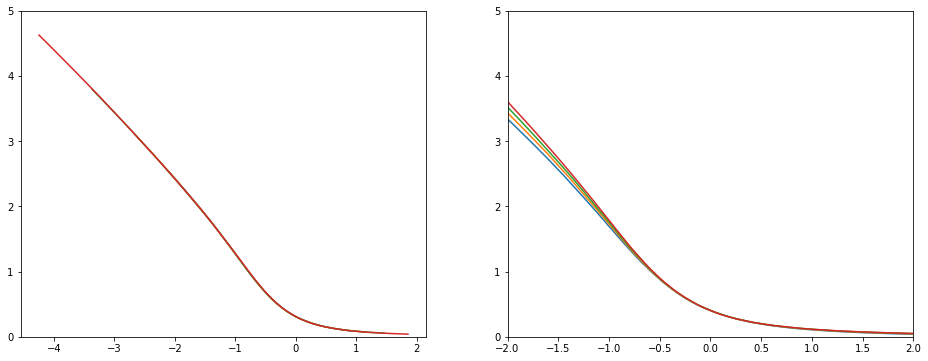

In [94]:
auto_scaled_data = fssa.scaledata(sizes, f_values, data['Sgcc'], data_err['Sgcc'], res_Sgcc.rho, res_Sgcc.nu, res_Sgcc.zeta)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

ax = axes[0]
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '-',
)
ax.set_ylim(0, 5)
#ax.set_xlim(-4, 2)

ax = axes[1]
for size in sizes:
    df = dfs[size]
    X = (df.f-fc)*size**(1/nu0)
    Y = df.Sgcc*size**(beta0/nu0)
    ax.plot(X, Y)
ax.set_ylim(0, 5)
ax.set_xlim(-2, 2)
plt.show()